In [37]:
%pip install pandas
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
%pip install matplotlib
%pip install onnx 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu128
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
import torch
import torchvision
import torchvision.transforms as transforms
import onnx

In [39]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 128

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

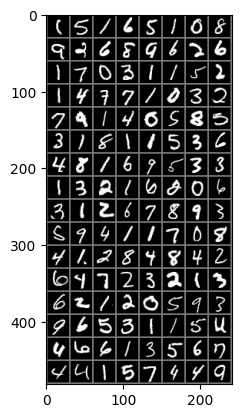

1     5     1     6     5     1     0     8     9     2     6     8     9     6     2     6     1     7     0     3     1     1     5     2     1     4     7     7     1     0     3     2     7     9     1     4     0     5     8     5     3     1     8     1     1     5     3     6     4     8     1     6     9     5     3     3     1     3     2     1     6     2     0     6     3     1     2     6     7     8     9     3     5     9     4     1     1     7     0     8     4     1     2     8     4     8     4     2     6     4     7     2     3     2     1     3     6     2     1     2     0     5     9     3     9     6     5     3     1     1     5     4     4     6     6     1     3     5     6     7     4     4     1     5     7     4     4     9    


In [40]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [41]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)          
        self.bn1 = nn.BatchNorm2d(6)            
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(6, 16, 5)             
        self.bn2 = nn.BatchNorm2d(16)               

        self.dropout = nn.Dropout(p=0.25)         

        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))   
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))       
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [42]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [43]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    scheduler.step()

print('Finished Training')

[1,     1] loss: 0.001
[1,   101] loss: 0.113
[1,   201] loss: 0.103
[1,   301] loss: 0.081
[1,   401] loss: 0.053
[2,     1] loss: 0.000
[2,   101] loss: 0.028
[2,   201] loss: 0.022
[2,   301] loss: 0.018
[2,   401] loss: 0.015
Finished Training


In [44]:
PATH = './model.pth'
torch.save(net.state_dict(), PATH)

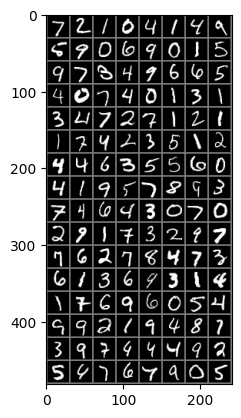

GroundTruth:  7     2     1     0    


In [45]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [46]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [47]:
outputs = net(images)

In [48]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  7     2     1     0    


In [49]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 93 %


In [50]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 98.0 %
Accuracy for class: 1     is 98.4 %
Accuracy for class: 2     is 92.3 %
Accuracy for class: 3     is 92.8 %
Accuracy for class: 4     is 94.3 %
Accuracy for class: 5     is 92.0 %
Accuracy for class: 6     is 94.8 %
Accuracy for class: 7     is 90.7 %
Accuracy for class: 8     is 90.9 %
Accuracy for class: 9     is 89.7 %


In [51]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [52]:
net.to(device)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [53]:
inputs, labels = data[0].to(device), data[1].to(device)

In [54]:
model = Net()
model.load_state_dict(torch.load(PATH, map_location="cpu"))
model.eval()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [55]:
dummy_input = torch.randn(1, 1, 28, 28)

torch.onnx.export(
    model,                   
    dummy_input,            
    "website/public/model.onnx",     
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    },
    opset_version=11 
)